Расчеты жб конструкций по нелинейной деформационной модели

In [1]:
import numpy as np
import pandas as pd
import sqlite3
from sqlite3 import Error
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.interpolate import griddata
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from PyNite.LoadCombo import LoadCombo
from prettytable import PrettyTable

In [2]:
def materials():
    """
    Свойства материалов.

    :return: Бетон, арматурная сталь
    """
    path = 'materials.db'  # База данных материалов
    con = None  # Соединение с базой данных
    try:
        con = sqlite3.connect(path)
        print(f"Соединение с SQLite DB '{path}' успешно !")
    except Error as e:
        print(f"Случилась ошибка '{e}'")
    finally:
        concrete = pd.read_sql(f"SELECT * FROM '{'concrete'}';", con, index_col='param', coerce_float=True)
        print(f"Таблица '{'concrete'}' загружена:")
        steel = pd.read_sql(f"SELECT * FROM '{'steel'}';", con, index_col='param', coerce_float=True)
        print(f"Таблица '{'steel'}' загружена:")
        con.close()
        return concrete, steel

In [3]:
def sigmac(eps, eb2, eb0, eb1, ebt1, ebt0, ebt2, rb, sb1, sbt1, rbt, e):
    """
    Диаграмма состояния бетона.

    :param eps: Относительная деформация
    :param eb2: Относительная деформация укорочения
    :param eb0: Относительная деформация укорочения
    :param eb1: Относительная деформация укорочения
    :param ebt1: Относительная деформация удлинения
    :param ebt0: Относительная деформация удлинения
    :param ebt2: Относительная деформация удлинения
    :param rb: Расчетное сопротивление бетона осевому сжатию, МПа
    :param sb1: Напряжение сжатия
    :param sbt1: Напряжение растяжения
    :param rbt: Расчетное сопротивление бетона осевому растяжению, МПа
    :param e: Mодуль упругости, МПа
    :return: Напряжение, МПа
    """

    if eb0 >= eps >= eb2:
        s = rb
    elif eb0 < eps < eb1:
        s = ((1 - sb1 / rb) * (eps - eb1) / (eb0 - eb1) + sb1 / rb) * rb
    elif eb1 <= eps < 0.0:
        s = e * eps
    elif ebt1 >= eps > 0.0 != sbt1:
        s = e * eps
    elif ebt1 < eps < ebt0 and rbt != 0.0:
        s = ((1 - sbt1 / rbt) * (eps - ebt1) / (ebt0 - ebt1) + sbt1 / rbt) * rbt
    elif ebt0 <= eps <= ebt2:
        s = rbt
    else:
        s = 0.0
    return s

In [4]:
def sigmas(eps, esc2, esc0, es0, es2, rsc, rs, e):
    """
    Диаграмма состояния арматурной стали.

    :param eps: Относительная деформация
    :param esc2: Относительная деформация укорочения
    :param esc0: Относительная деформация укорочения
    :param es0: Относительная деформация удлинения
    :param es2: Относительная деформация удлинения
    :param rsc: Расчетное сопротивление арматуры сжатию, МПа
    :param rs: Расчетное сопротивление арматуры растяжению, МПа
    :param e: Mодуль упругости, МПа
    :return: Напряжение, МПа
    """

    if esc0 >= eps >= esc2:
        s = rsc
    elif esc0 < eps < es0:
        s = e * eps
    elif es0 <= eps <= es2:
        s = rs
    else:
        s = 0.0
    return s

In [5]:
def strainstress(x, y, grade):
    """
    Диаграмма состояния.
    """

    fig, ax = plt.subplots(num='Диаграмма состояния ' + grade)
    ax.plot(x, y)
    ax.set_xlabel('Относительные деформации')
    ax.set_ylabel('Напряжения, МПа')
    plt.title('Диаграмма состояния ' + grade)
    ax.scatter(x, y, c='red', alpha=0.5)
    plt.show()

In [6]:
concrete, steel = materials()

Соединение с SQLite DB 'materials.db' успешно !
Таблица 'concrete' загружена:
Таблица 'steel' загружена:


In [7]:
print(concrete)

               B15          B20          B25          B30          B35  \
param                                                                    
eb2       -0.00350     -0.00350     -0.00350     -0.00350     -0.00350   
eb0       -0.00200     -0.00200     -0.00200     -0.00200     -0.00200   
ebt0       0.00010      0.00010      0.00010      0.00010      0.00010   
ebt2       0.00015      0.00015      0.00015      0.00015      0.00015   
Rb        -8.50000    -11.50000    -14.50000    -17.00000    -19.50000   
Rbt        0.75000      0.90000      1.05000      1.15000      1.30000   
E      24000.00000  27500.00000  30000.00000  32500.00000  34500.00000   

               B40          B45          B50          B55          B60  \
param                                                                    
eb2       -0.00350     -0.00350     -0.00350     -0.00350     -0.00350   
eb0       -0.00200     -0.00200     -0.00200     -0.00200     -0.00200   
ebt0       0.00010      0.00010      

In [8]:
print(steel)

               A240          A400           A500
param                                           
esc2       -0.02500      -0.02500      -0.025000
esc0       -0.00105      -0.00175      -0.002000
es0         0.00105       0.00175       0.002175
es2         0.02500       0.02500       0.025000
Rsc      -210.00000    -350.00000    -400.000000
Rs        210.00000     350.00000     435.000000
E      200000.00000  200000.00000  200000.000000


Решатель

In [9]:
class Calculation:
    """Решение"""

    @staticmethod
    def calc(d, f):
        """
        Получение вектора деформаций.

        :param d: Матрица жесткости
        :param f: Вектор нагрузок
        :return: Вектор деформаций
        """
        try:
            u = np.linalg.solve(d, f)
        except np.linalg.LinAlgError as var1:
            d = np.eye(3)
            fi = np.array(([0.0, 0.0, 0.0]))
            u = np.linalg.solve(d, fi)
            print('Решение невозможно:', var1)
            quit()
        return u

Арматурный стержень

In [10]:
class Rebar:
    """Класс представляющий арматурный стержень"""

    def __init__(self, name, grade, ds, x, y, steel):
        """
        Инициализация арматурного стержня

        :param name: Имя стержня
        :param grade: Класс арматуры, из списка в English A240  A400    A500
        :param ds: Диаметр стержня, мм
        :param x: Координата x, мм
        :param y: Координата y, мм
        :param steel: Данные по стали
        """
        self.name = name
        self.grade = grade
        self.ds = ds / 1000
        self.x = x / 1000
        self.y = y / 1000
        self.steel = steel
        self.strain = {}  # Относительные деформации
        self.stress = {}  # Напряжения, МПа

    @property
    def st(self):
        """Свойства стали арматурного стержня"""
        s = self.steel[self.grade]
        return s

    @property
    def asj(self):
        """Площадь поперечного сечения арматурного стержня, м^2"""
        as_j = np.pi * self.ds ** 2 / 4
        return as_j

Поперечное сечение

In [11]:
class Rectangle:
    """Класс представляющий бетонное прямоугольное сечение"""

    def __init__(self, grade, h, b, nh, nb, concrete):
        """
        Инициализация прямоугольного бетонного сечения

        :param grade: Класс бетона, из списка в English B15	B20	B25	B30	B35	B40	B45	B50	B55	B60	B70	B80	B90	B100
        :param h: Высота сечения, мм
        :param b: Ширина сечения, мм
        :param nh: Число КЭ по высоте сечения
        :param nb: Число КЭ по ширине сечения
        :param concrete: Данные по бетону
        """
        self.grade = grade
        self.h = h / 1000
        self.b = b / 1000
        self.nh = nh
        self.nb = nb
        self.concrete = concrete

    @property
    def conc_prop(self):
        """Свойства бетона сечения"""

        c = self.concrete[self.grade]
        return c

    @property
    def conc_geometry(self):
        """
        Геометрические характеристики прямоугольного сечения.

        :return: Геометрические характеристики прямоугольного сечения
        """

        dh = self.h / self.nh
        db = self.b / self.nb
        ab = dh * db
        nb = self.nh * self.nb
        ab_i = np.linspace(ab, ab, nb)
        secb = np.zeros((nb, 2))
        for i in range(0, self.nb):
            for j in range(0, self.nh):
                secb[j + i * self.nh, 0] = -self.h / 2 + dh * j + dh / 2
                secb[j + i * self.nh, 1] = -self.b / 2 + db * i + db / 2
        xb1_2 = np.linspace(-self.h / 2, self.h / 2, self.nh + 1)
        yb1_2 = np.linspace(-self.b / 2, -self.b / 2, self.nh + 1)
        xb2_4 = np.linspace(self.h / 2, self.h / 2, self.nb - 2)
        yb2_4 = np.linspace(-self.b / 2 + db, self.b / 2 - db, self.nb - 2)
        xb4_3 = np.linspace(self.h / 2, -self.h / 2, self.nh + 1)
        yb4_3 = np.linspace(self.b / 2, self.b / 2, self.nh + 1)
        xb3_1 = np.linspace(-self.h / 2, -self.h / 2, self.nb - 2)
        yb3_1 = np.linspace(self.b / 2 - db, -self.b / 2 + db, self.nb - 2)
        abi = np.hstack([ab_i, np.zeros(2 * (len(xb1_2) + len(xb2_4)))])
        xbi = np.hstack([secb[:, 0], xb1_2, xb2_4, xb4_3, xb3_1])
        ybi = np.hstack([secb[:, 1], yb1_2, yb2_4, yb4_3, yb3_1])
        a = np.sum(abi)
        ix = np.sum(ab_i * secb[:, 1] ** 2)
        iy = np.sum(ab_i * secb[:, 0] ** 2)
        ci = [nb, nb + self.nh, nb + self.nh + self.nb - 1, nb + 2 * self.nh + self.nb - 1]
        zb = np.transpose(np.array([np.ones(len(xbi)), xbi, ybi]))
        g = [xbi, ybi, abi, zb, ci, a, ix, iy]
        return g

Графики

In [12]:
def loads(img):
    """
    Правило знаков нагрузок.

    :param img: Файл рисунка
    :return:
    """
    fig, ax = plt.subplots(num='Правило знаков нагрузок')
    ax.imshow(mpimg.imread(img))
    ax.axis('off')
    plt.title('Правило знаков нагрузок')
    plt.show()

In [13]:
def strain2d(eb, es, xbi, ybi, xsj, ysj, asj, ci):
    """Относительные деформации в железобетонном сечении."""

    xc = xbi
    yc = ybi
    zc = eb
    epsmin = min(zc)
    epsmax = max(zc)
    x_min = np.array(xc[zc == epsmin][:1])[0]
    y_min = np.array(yc[zc == epsmin][:1])[0]
    x_max = np.array(xc[zc == epsmax][:1])[0]
    y_max = np.array(yc[zc == epsmax][:1])[0]
    x1 = np.linspace(xc.min(), xc.max(), len(xc))
    y1 = np.linspace(yc.min(), yc.max(), len(yc))
    x2, y2 = np.meshgrid(x1, y1)
    z2 = griddata((xc, yc), zc, (x1[None, :], y1[:, None]), method='linear')
    clipindex = ci
    fig, ax = plt.subplots(num=strain2d.__doc__)
    ax.set_xlabel('X, м')
    ax.set_ylabel('Y, м')
    ax.set_aspect('equal')
    plt.subplots_adjust(left=0.185, right=0.815, bottom=0.1, top=0.9)
    plt.title(strain2d.__doc__, pad=20)
    cont = ax.contourf(x2, y2, z2, 20, alpha=0.6, cmap="rainbow")
    clippath = Path(np.c_[xbi[clipindex], ybi[clipindex]])
    patch = PathPatch(clippath, facecolor='none', edgecolor='k')
    ax.add_patch(patch)
    for col in cont.collections:
        col.set_clip_path(patch)
    xr = xsj
    yr = ysj
    zr = es
    a_s = asj
    ds = np.sqrt(4 * a_s / np.pi)
    ax.scatter(xr, yr, s=ds * 8000, c='green', alpha=0.5)
    ax.scatter(x_min, y_min, s=100, c='blue')
    ax.scatter(x_max, y_max, s=100, c='red')
    ax.annotate(round(epsmin, 5), (x_min, y_min), size=10, xytext=(
        0, 10), ha='right', color='blue', textcoords='offset points')
    ax.annotate(round(epsmax, 5), (x_max, y_max), size=10, xytext=(
        0, 10), ha='left', color='red', textcoords='offset points')
    for i, txt in enumerate(zr):
        ax.annotate(round(txt, 5), (xr[i], yr[i]), size=10, xytext=(
            0, 0), ha='center', textcoords='offset points')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='10%', pad=0.75)
    plt.colorbar(cont, cax=cax)
    plt.show()


def stress2d(sb, ss, xbi, ybi, xsj, ysj, asj, ci):
    """Напряжения в железобетонном сечении, МПа."""

    xc = xbi
    yc = ybi
    zc = sb
    stressmin = min(zc)
    stressmax = max(zc)
    x_min = np.array(xc[zc == stressmin][:1])[0]
    y_min = np.array(yc[zc == stressmin][:1])[0]
    x_max = np.array(xc[zc == stressmax][:1])[0]
    y_max = np.array(yc[zc == stressmax][:1])[0]
    x1 = np.linspace(xc.min(), xc.max(), len(xc))
    y1 = np.linspace(yc.min(), yc.max(), len(yc))
    x2, y2 = np.meshgrid(x1, y1)
    z2 = griddata((xc, yc), zc, (x1[None, :], y1[:, None]), method='linear')
    clipindex = ci
    fig, ax = plt.subplots(num=stress2d.__doc__)
    ax.set_xlabel('X, м')
    ax.set_ylabel('Y, м')
    ax.set_aspect('equal')
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    plt.title(stress2d.__doc__, pad=20)
    cont = ax.contourf(x2, y2, z2, 20, alpha=0.6, cmap="rainbow")
    clippath = Path(np.c_[xbi[clipindex], ybi[clipindex]])
    patch = PathPatch(clippath, facecolor='none', edgecolor='k')
    ax.add_patch(patch)
    for col in cont.collections:
        col.set_clip_path(patch)
    xr = xsj
    yr = ysj
    zr = ss
    a_s = asj
    ds = np.sqrt(4 * a_s / np.pi)
    ax.scatter(xr, yr, s=ds * 8000, c='green', alpha=0.5)
    ax.scatter(x_min, y_min, s=100, c='blue')
    ax.scatter(x_max, y_max, s=100, c='red')
    ax.annotate(round(stressmin, 2), (x_min, y_min), size=10, xytext=(
        0, 10), ha='right', color='blue', textcoords='offset points')
    ax.annotate(round(stressmax, 2), (x_max, y_max), size=10, xytext=(
        0, 10), ha='left', color='red', textcoords='offset points')
    for i, txt in enumerate(zr):
        ax.annotate(round(txt, 2), (xr[i], yr[i]), size=10, xytext=(
            0, 0), ha='center', textcoords='offset points')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='10%', pad=0.75)
    plt.colorbar(cont, cax=cax)
    plt.show()


def strain3d(eb, xbi, ybi):
    """Относительные деформации в железобетонном сечении."""

    xc = xbi
    yc = ybi
    zc = eb
    x1 = np.linspace(xc.min(), xc.max(), len(xc))
    y1 = np.linspace(yc.min(), yc.max(), len(yc))
    x2, y2 = np.meshgrid(x1, y1)
    fig = plt.figure(num=strain3d.__doc__)
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    ax = plt.axes(projection='3d')
    ax.set_aspect('auto')
    ax.set_xlabel('X, м')
    ax.set_ylabel('Y, м')
    ax.set_zlabel(zlabel='Относительные деформации')
    z2 = griddata((xc, yc), zc, (x2, y2), method='linear')
    surf = ax.plot_surface(x2, y2, z2, cmap="rainbow", alpha=0.8, linewidth=1)
    plt.title(strain3d.__doc__, pad=10)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    fig.colorbar(surf, orientation='vertical', shrink=0.5, aspect=5, pad=0.1)
    plt.show()


def stress3d(sb, xbi, ybi):
    """Напряжения в железобетонном сечении, МПа."""

    xc = xbi
    yc = ybi
    zc = sb
    x1 = np.linspace(xc.min(), xc.max(), len(xc))
    y1 = np.linspace(yc.min(), yc.max(), len(yc))
    x2, y2 = np.meshgrid(x1, y1)
    fig = plt.figure(num=stress3d.__doc__)
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    ax = plt.axes(projection='3d')
    ax.set_aspect('auto')
    ax.set_xlabel('X, м')
    ax.set_ylabel('Y, м')
    ax.set_zlabel(zlabel='Напряжения, МПа')
    z2 = griddata((xc, yc), zc, (x2, y2), method='linear')
    surf = ax.plot_surface(x2, y2, z2, cmap="rainbow", alpha=0.8, linewidth=1)
    plt.title(stress3d.__doc__, pad=10)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    fig.colorbar(surf, orientation='vertical', shrink=0.5, aspect=5, pad=0.1)
    plt.show()

Результаты

In [14]:
class Result:
    """Класс представляющий результаты расчета"""

    def __init__(self, vsigmac, vsigmas, section, rebars):
        """
        Инициализация результатов расчета.

        :param vsigmac: Векторизованная функция бетона
        :param vsigmas: Векторизованная функция арматуры
        :param section: Бетонное сечение
        :param rebars: Арматурные стержни
        """
        self.vsigmac = vsigmac
        self.vsigmas = vsigmas
        self.section = section
        self.rebars = rebars

    def results(self, f, u, abi, xbi, ybi, e_b, eb, s_b, sb, asj, xsj, ysj, es, ss, c_g, c_p):
        """
        Вывод результатов расчета.

        :param f: Вектор нагрузки
        :param u: Вектор деформаций
        :param abi: Площади КЭ бетона
        :param xbi: Координаты x КЭ бетона
        :param ybi: Координаты y КЭ бетона
        :param e_b: Относительные деформации бетона
        :param eb: Результаты относительных деформаций бетона
        :param s_b: Напряжения бетона
        :param sb: Результаты напряжений бетона
        :param asj: Площади арматурных стержней
        :param xsj: Координаты x арматурных стержней
        :param ysj: Координаты y арматурных стержней
        :param es: Результаты относительных деформаций арматуры
        :param ss: Результаты напряжений арматуры
        :param c_g: Геометрия КЭ бетона
        :param c_p: Свойства бетона
        :return:
        """
        i = 0
        for name in self.rebars.keys():
            self.rebars[name].strain = es[i]
            self.rebars[name].stress = ss[i]
            i += 1
        ep = np.zeros(2)
        sp = np.zeros(2)
        ep[0] = round(min(eb), 6)
        ep[1] = round(max(es), 6)
        sp[0] = round(min(sb), 6)
        sp[1] = round(max(ss), 6)
        print('Относительные деформации, напряжения [МПа]:')
        df = PrettyTable(['Значение', 'Бетон[min]', 'Арматура[max]'])
        df.add_row(['Деформации', ep[0], ep[1]])
        df.add_row(['Напряжения', sp[0], sp[1]])
        print(df)
        print('Проверка:')
        nr = 8
        cloads = np.round(1000 * np.array((sum(sb * np.array(abi)) + sum(ss * np.array(asj)),
                                           sum(sb * np.array(abi) * np.array(xbi)) + sum(
                                               ss * np.array(asj) * np.array(xsj)),
                                           sum(sb * np.array(abi) * np.array(ybi)) + sum(
                                               ss * np.array(asj) * np.array(ysj)))), nr)
        ptl = PrettyTable(["Нагрузка", "N, кН", "Mx, кН*м", "My, кН*м"])
        ptl.add_row(["Заданная", np.round(f[0] * 1000, nr), np.round(f[1] * 1000, nr), np.round(f[2] * 1000, nr)])
        ptl.add_row(["Полученная", cloads[0], cloads[1], cloads[2]])
        ptl.add_row(["u", np.round(u[0], nr), np.round(u[1], nr), np.round(u[2], nr)])
        print(ptl)
        print('Арматурные стержни:')
        ptr = PrettyTable(["Имя", "X, мм", "Y, мм", "Диаметр, мм", "Класс", "Деформации", "Напряжения, МПа"])
        for i in self.rebars:
            ptr.add_row(
                [i, self.rebars[i].x * 1000, self.rebars[i].y * 1000, self.rebars[i].ds * 1000, self.rebars[i].grade,
                 np.round(self.rebars[i].strain, 6), np.round(self.rebars[i].stress, 2)])
        print(ptr)
        arge = [eb, es, xbi, ybi, np.array(xsj), np.array(ysj), np.array(asj), c_g[4]]
        args = [sb, ss, xbi, ybi, np.array(xsj), np.array(ysj), np.array(asj), c_g[4]]
        sigmac = self.vsigmac(e_b, *e_b, *s_b, c_p['E'])  # Напряжения в бетоне для диаграммы состояния
        loads('member_section.png')  # Правило знаков нагрузок
        strainstress(e_b, sigmac, self.section.grade)  # Диаграмма состояния бетона
        rbrs = {}  # Словарь арматурных стержней с уникальными классами
        for key in self.rebars.keys():
            rbrs[self.rebars[key].grade] = self.rebars[key]
        for key in rbrs.keys():
            s_s = [rbrs[key].st['Rsc'], rbrs[key].st['Rs']]
            e_s = [rbrs[key].st['esc2'], rbrs[key].st['esc0'], rbrs[key].st['es0'], rbrs[key].st['es2']]
            sigmas = self.vsigmas(e_s, *e_s, *s_s, rbrs[key].st['E'])
            strainstress(e_s, sigmas, key)  # Диаграмма состояния арматуры
        strain2d(*arge)  # График деформаций в сечении 2D
        strain3d(eb, xbi, ybi)  # График деформаций в сечении 3D
        stress2d(*args)  # График напряжений в сечении 2D
        stress3d(sb, xbi, ybi)  # График напряжений в сечении 3D

Поперечное сечение

In [15]:
class FrameSec:
    """Класс преставляющий нормальное поперечное сечение жб стержневого КЭ"""

    def __init__(self, concrete, steel):
        """Инициализация сечения жб стержневого КЭ."""

        self.section = None  # Поперечное сечение
        self.concrete = concrete  # Данные по бетону
        self.steel = steel  # Данные по стали
        self.rebars = {}  # Словарь арматурных стержней
        self.Loads = []  # Список нагрузок
        self.loadcombos = {}  # Словарь комбинаций нагрузок
        self.c_p = None  # Свойства бетона
        self.c_g = None  # Свойства геометрии

    def add_rect_section(self, grade, h, b, nh, nb):
        """
        Добавляет новое прямоугольное бетонное сечение в поперечное жб сечение

        :param grade: Класс бетона, из списка в English B15	B20	B25	B30	B35	B40	B45	B50	B55	B60	B70	B80	B90	B100
        :param h: Высота сечения, мм
        :param b: Ширина сечения, мм
        :param nh: Число КЭ по высоте сечения
        :param nb: Число КЭ по ширине сечения
        :return:
        """

        # Создает новое бетонное сечение
        self.section = Rectangle(grade, h, b, nh, nb, self.concrete)
        self.c_p = self.section.conc_prop  # Свойства бетона
        self.c_g = self.section.conc_geometry  # Геометрия бетона

    def add_rebar(self, name, grade, ds, x, y):
        """
        Добавляет новый арматурный стержень в жб сечение.

        :param name: Имя стержня
        :param grade: Класс арматуры, из списка в English A240   A400	A500
        :param ds: Диаметр стержня, мм
        :param x: Координата x, мм
        :param y: Координата y, мм
        :return:
        """

        # Создает новый стержень
        new_rebar = Rebar(name, grade, ds, x, y, self.steel)
        # Добавляет новый стержень в коллекцию
        self.rebars[name] = new_rebar

    def add_load(self, n, mx, my, case='Case 1'):
        """
        Добавляет нагрузку в сечение.

        :param n: Продольная сила, кН (+ растяжение)
        :param mx: Изгибающий момент вдоль оси X, кН*м
        :param my: Изгибающий момент вдоль оси Y, кН*м
        :param case: Имя загружения, строка
        :return:
        """
        self.Loads.append((n, mx, my, case))

    def add_load_combo(self, name, factors, combo_type='strength'):
        """
        Добавляет комбинацию нагрузок к сечению

        :param name: Уникальное имя комбинации ('1.1D+1.2L')
        :param factors: Словарь включающий нагрузки и их коэффициенты ({'D': 1.1, 'L': 1.2}).
        :param combo_type: Тип комбинации нагрузок
        :return:
        """
        # Создает новую комбинацию
        new_combo = LoadCombo(name, combo_type, factors)
        # Добавляет комбинацию к словарю
        self.loadcombos[name] = new_combo

    @staticmethod
    def d(ai, xi, yi, ei, vi):
        """
        Жесткостные характеристики поперечного сечения.

        :param ai: Площади, м^2
        :param xi: Координаты по x, м
        :param yi: Координаты по y, м
        :param ei: Mодули упругости, МПа
        :param vi: Коэффициенты упругости
        :return: Матрица жесткости
        """
        d00 = sum(ai * ei * vi)
        d11 = sum(ai * xi ** 2 * ei * vi)
        d22 = sum(ai * yi ** 2 * ei * vi)
        d01 = sum(ai * xi * ei * vi)
        d02 = sum(ai * yi * ei * vi)
        d12 = sum(ai * xi * yi * ei * vi)
        d = np.array([
            [d00, d01, d02],
            [d01, d11, d12],
            [d02, d12, d22]])
        return d

    @staticmethod
    def vi(s, e, eps):
        """
        Коэффициент упругости.

        :param s: Напряжение, МПа
        :param e: Mодуль упругости, МПа
        :param eps: Относительная деформация
        :return: Коэффициент упругости
        """

        if eps != 0.0:
            v = s / e / eps
        else:
            v = 1.0
        return v

    def force(self, combo_name):
        """
        Собирает вектор нагрузки.

        :param combo_name: Имя комбинации для вектора нагрузки
        :return: Вектор нагрузки, [МН, МН*м, МН*м]
        """
        f = np.zeros(3)
        combo = self.loadcombos[combo_name]
        for case, factor in combo.factors.items():
            for load in self.Loads:
                if load[3] == case:
                    f[0] += factor * load[0] / 1000
                    f[1] += factor * load[1] / 1000
                    f[2] += factor * load[2] / 1000
        return f

    def analyze(self, combo_name, kt, gb3, acc):
        """
        Расчет железобетонного сечения.

        :param combo_name: Имя расчетной комбинации нагрузок
        :param kt: Коэффициент учета растяжения бетона
        :param gb3: Коэффициент gb3 бетона
        :param acc: Точность расчета
        :return:
        """

        vv = np.vectorize(self.vi)
        vsigmac = np.vectorize(sigmac)
        vsigmas = np.vectorize(sigmas)
        s_b = [self.c_p['Rb'] * gb3, self.c_p['Rb'] * 0.6 * gb3, self.c_p['Rbt'] * 0.6 * kt, self.c_p['Rbt'] * kt]
        e_b = [self.c_p['eb2'], self.c_p['eb0'], s_b[1] / self.c_p['E'], s_b[2] / self.c_p['E'], self.c_p['ebt0'],
               self.c_p['ebt2']]
        xbi = self.c_g[0]
        ybi = self.c_g[1]
        abi = self.c_g[2]
        zb = self.c_g[3]
        n_b = len(xbi)
        ebi = np.linspace(self.c_p['E'], self.c_p['E'], n_b)
        xsj = []
        ysj = []
        asj = []
        rsc = []
        rs = []
        esc2 = []
        esc0 = []
        es0 = []
        es2 = []
        esj = []
        for name in self.rebars.keys():
            xsj.append(self.rebars[name].x)
            ysj.append(self.rebars[name].y)
            asj.append(self.rebars[name].asj)
            rsc.append(self.rebars[name].st['Rsc'])
            rs.append(self.rebars[name].st['Rs'])
            esc2.append(self.rebars[name].st['esc2'])
            esc0.append(self.rebars[name].st['esc0'])
            es0.append(self.rebars[name].st['es0'])
            es2.append(self.rebars[name].st['es2'])
            esj.append(self.rebars[name].st['E'])
        n_s = len(xsj)
        zs = np.transpose(np.array([np.ones(n_s), xsj, ysj]))
        f = self.force(combo_name)
        vbi = np.linspace(1, 1, n_b)
        vsj = np.linspace(1, 1, n_s)
        d = self.d(abi, xbi, ybi, ebi, vbi) + self.d(np.array(asj), np.array(xsj), np.array(ysj), np.array(esj), vsj)
        u = Calculation.calc(d, f)  # Вектор общих деформаций
        eb = zb.dot(u)  # Деформации бетона
        sb = vsigmac(eb, *e_b, *s_b, ebi)  # Напряжения в бетоне
        es = zs.dot(u)  # Деформации арматуры
        ss = np.zeros(n_s)  # Напряжения в арматуре
        for i in range(n_s):
            ss[i] = sigmas(es[i], esc2[i], esc0[i], es0[i], es2[i], rsc[i], rs[i], esj[i])
        du = 0.1
        it = 0
        while du >= acc:
            it += 1
            vb = vv(sb, ebi, eb)
            vs = vv(ss, esj, es)
            d = self.d(abi, xbi, ybi, ebi, vb) + self.d(np.array(asj), np.array(xsj), np.array(ysj), np.array(esj), vs)
            u_f = Calculation.calc(d, f)  # Вектор общих деформаций
            eb = zb.dot(u_f)  # Деформации бетона
            sb = vsigmac(eb, *e_b, *s_b, ebi)  # Напряжения в бетоне
            es = zs.dot(u_f)  # Деформации арматуры
            ss = np.zeros(n_s)  # Напряжения в арматуре
            for i in range(n_s):
                ss[i] = sigmas(es[i], esc2[i], esc0[i], es0[i], es2[i], rsc[i], rs[i], esj[i])
            du = np.max(abs(u - u_f))
            u = u_f  # Вектор общих деформаций
        print('Решение получено')
        print('Выполнено', it, 'итераций')
        print('Бетон класса:', self.section.grade)
        print('Коэффициент работы бетона на растяжение: ', kt)
        print('Коэффициент gb3: ', gb3)
        res = Result(vsigmac, vsigmas, self.section, self.rebars)
        res.results(f, u, abi, xbi, ybi, e_b, eb, s_b, sb, asj, xsj, ysj, es, ss, self.c_g, self.c_p)

Создание жб поперечного сечения с нагрузками

In [16]:
def main():
    # Свойства материалов
    concrete, steel = materials()

    # Создание нового прямоугольного жб сечения
    rect = FrameSec(concrete, steel)

    # Создание прямоугольного бетонного сечения
    rect.add_rect_section('B30', 500, 400, 10, 8)

    # Создание стержней
    rect.add_rebar('0', 'A500', 28, 210, -160)
    rect.add_rebar('1', 'A400', 14, 210, 0)
    rect.add_rebar('2', 'A500', 28, 210, 160)
    rect.add_rebar('3', 'A400', 14, 0, -160)
    rect.add_rebar('4', 'A400', 14, 0, 160)
    rect.add_rebar('5', 'A500', 28, -210, -160)
    rect.add_rebar('6', 'A400', 14, -210, 0)
    rect.add_rebar('7', 'A500', 28, -210, 160)

    # Добавить нагрузки
    rect.add_load(-1000, 160, 70, case='D')
    rect.add_load(-500, 160, 70, case='L')

    # Создание комбинаций
    rect.add_load_combo('1.0D+1.0L', factors={'D': 1.0, 'L': 1.0})
    rect.add_load_combo('1.1D+1.2L', factors={'D': 1.1, 'L': 1.2})

    combo_name = '1.0D+1.0L'
    kt = 0
    gb3 = 1
    rect.analyze(combo_name, kt, gb3, 0.0000001)

Соединение с SQLite DB 'materials.db' успешно !
Таблица 'concrete' загружена:
Таблица 'steel' загружена:
Решение получено
Выполнено 49 итераций
Бетон класса: B30
Коэффициент работы бетона на растяжение:  0
Коэффициент gb3:  1
Относительные деформации, напряжения [МПа]:
+------------+------------+---------------+
|  Значение  | Бетон[min] | Арматура[max] |
+------------+------------+---------------+
| Деформации | -0.003432  |    0.002388   |
| Напряжения |   -17.0    |     435.0     |
+------------+------------+---------------+
Проверка:
+------------+----------------+--------------+--------------+
|  Нагрузка  |     N, кН      |   Mx, кН*м   |   My, кН*м   |
+------------+----------------+--------------+--------------+
|  Заданная  |    -1500.0     |    320.0     |    140.0     |
| Полученная | -1499.99163294 | 319.99760126 | 139.99825403 |
|     u      |  -0.00024154   |  0.00767403  |  0.00636224  |
+------------+----------------+--------------+--------------+
Арматурные стержни:
+-

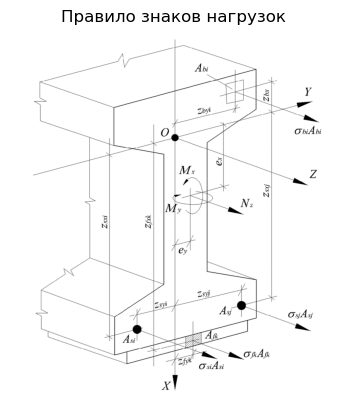

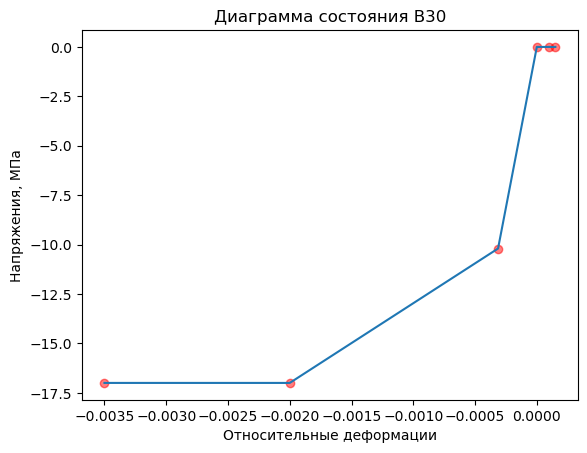

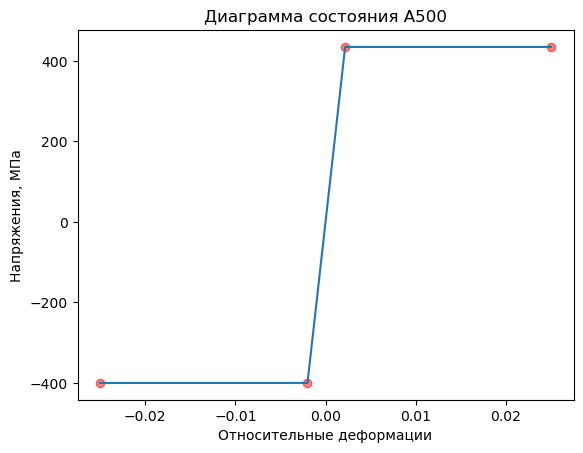

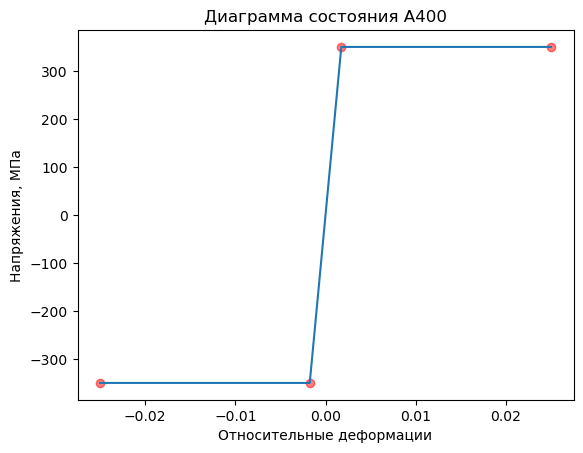

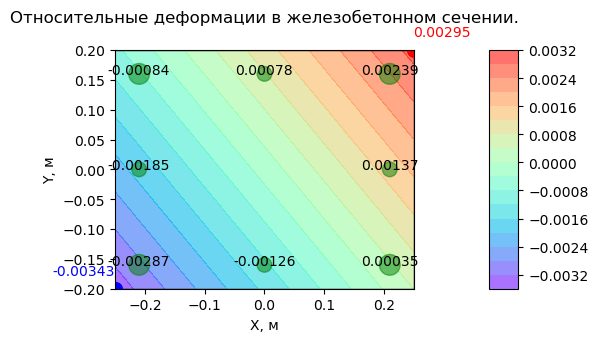

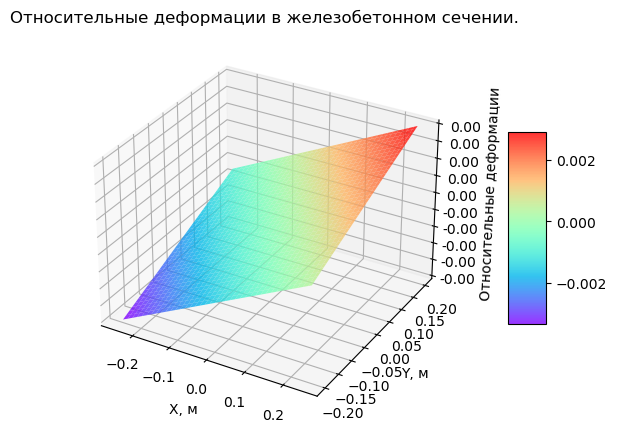

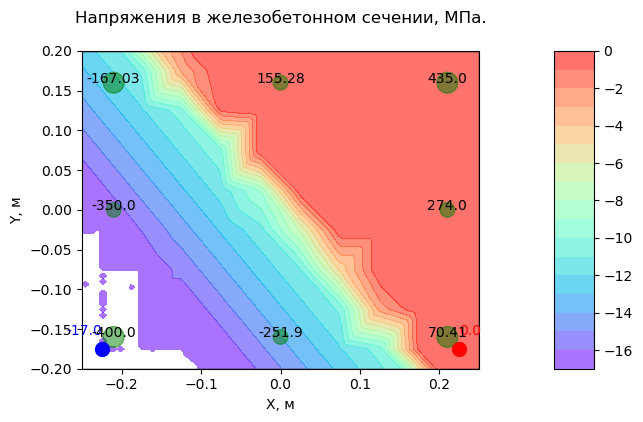

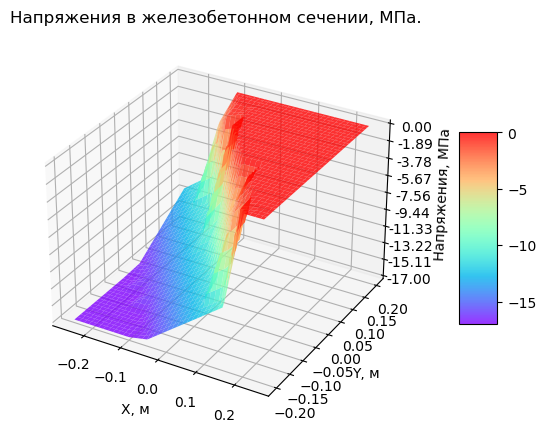

In [17]:
main()